##### Libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlencode
import scipy.stats as stats
from scipy.stats import norm

from tqdm.auto import tqdm

plt.style.use('ggplot')

<h1><center>Mobile game "Plants & Gardens"</center></h1>

### К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:
1. В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.
2. Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.
3. Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

  ### Task 1

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

* shared/problem1-reg_data.csv – данные о времени регистрации

| reg_ts | uid |
|--------|-----|
|906166566| 2 |
|906344325| 2 |
|906686169| 2 |
|906893386| 2 |
|906980227| 2 |

* shared/problem1-auth_data.csv – данные о времени захода пользователей в игру

| auth_ts | uid |
|---------|-----|
|906166566|	2   |
|924422172|	3   |
|937374732|	4   |
|947425117|	5   |
|955630339|	6   |

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

###### для начала загрузим данные и проверим структуру данных

In [2]:
def get_data(file_url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    final_url = base_url + urlencode(dict(public_key=file_url))
    r = requests.get(final_url)
    download_url = r.json()['href']
    df = pd.read_csv(download_url, sep=';')
    return df 

In [3]:
# ссылки на исходные данные
reg = 'https://disk.yandex.ru/d/4_L7TaaZbaFwOw'
auth = 'https://disk.yandex.ru/d/Tnl_1pwMxslKNQ'

In [4]:
df_reg = get_data(reg)
df_reg.head(5)

,reg_ts,uid
0,911382223,1
1,932683089,2
2,947802447,3
3,959523541,4
4,969103313,5


In [5]:
df_auth = get_data(auth)
df_auth.head(5)  # видим что время представлено в виде unix формата

,auth_ts,uid
0,911382223,1
1,932683089,2
2,932921206,2
3,933393015,2
4,933875379,2


In [6]:
df_reg.shape

(1000000, 2)

In [7]:
df_auth.shape

(9601013, 2)

In [8]:
df = pd.merge(df_reg, df_auth, on='uid', how='left')  # мерджим таблицы для дальнейшей работы
df = df[['uid', 'reg_ts', 'auth_ts']]
df.head(5)

,uid,reg_ts,auth_ts
0,1,911382223,911382223
1,2,932683089,932683089
2,2,932683089,932921206
3,2,932683089,933393015
4,2,932683089,933875379


In [9]:
df['reg_time'] = pd.to_datetime(df['reg_ts'], unit='s', utc=False).dt.floor('d')  # объем данных большой, поэтому
df['auth_time'] = pd.to_datetime(df['auth_ts'], unit='s', utc=False).dt.floor('d')  # используем оптимальный метод
df.head(5)

,uid,reg_ts,auth_ts,reg_time,auth_time
0,1,911382223,911382223,1998-11-18,1998-11-18
1,2,932683089,932683089,1999-07-22,1999-07-22
2,2,932683089,932921206,1999-07-22,1999-07-25
3,2,932683089,933393015,1999-07-22,1999-07-31
4,2,932683089,933875379,1999-07-22,1999-08-05


In [10]:
df.shape  # проверим что данные все на месте

(9601013, 5)

In [11]:
df = df.drop(columns=['reg_ts', 'auth_ts'])  # сбросим уже ненужные колонки

In [12]:
df.dtypes  # проверим форматы колонок

uid                   int64
reg_time     datetime64[ns]
auth_time    datetime64[ns]
dtype: object

In [13]:
too_synthetic_to_be_true = df.groupby('reg_time').agg({'uid': pd.Series.nunique})  # изучаем данные чтобы понять 
too_synthetic_to_be_true.head(10)  # с каким объемом пользователей будем работать

,uid
reg_time,
1998-11-18,1
1999-07-22,1
2000-01-13,1
2000-05-28,1
2000-09-16,1
2000-12-19,1
2001-03-10,1
2001-05-21,1
2001-07-24,1


In [14]:
too_synthetic_to_be_true.query('reg_time > "2020-09-01"').head(10)

,uid
reg_time,
2020-09-02,1588
2020-09-03,1591
2020-09-04,1593
2020-09-05,1596
2020-09-06,1599
2020-09-07,1601
2020-09-08,1604
2020-09-09,1607
2020-09-10,1609


In [15]:
df.isnull().values.sum()  # на всякий случай проверяем на NaN

0

In [16]:
df.head(10)  # можно начать работать с этим датафреймом

,uid,reg_time,auth_time
0,1,1998-11-18,1998-11-18
1,2,1999-07-22,1999-07-22
2,2,1999-07-22,1999-07-25
3,2,1999-07-22,1999-07-31
4,2,1999-07-22,1999-08-05
5,2,1999-07-22,1999-08-11
6,2,1999-07-22,1999-08-14
7,2,1999-07-22,1999-08-18
8,2,1999-07-22,1999-08-20
9,2,1999-07-22,1999-08-26


<h5><h5 style="color:#ff0000">основаня идея:</h5><h5> отдаем на вход датафрейм, начальную дату от которой хотим получить таблицу ретеншн рейтов, число дней после начальной даты, то есть мы имеем временной промежуток даты регистрации новых пользователей и вводим количество N-дней на которое хотим получить отчетную таблицу. При чем будем придерживаться "классического" когортного паттерна расчета коэфициента удержания на основе расчета таймдельты, для того чтобы узнать количество оставшихся пользователей. Затем оптимизируем работу функции.</h5>

In [20]:
def retention_rate(df, start_date=None, end_offset=None, num_days=None):
    """
    вводные данные: df-наш датафрейм, начальная дата должна
    быть введена через '', задаем конечную дату через оффсет, то есть сколько дней отобразится после стартовой даты 
    и количество N дней.
    """
    if start_date is None:  # если не задана переменная, то стартовая дата это самая поздняя дата в датафрейме
        start_date = df['reg_time'].min()
    else:
        start_date = pd.to_datetime(start_date)  # либо же задаем сами
        
    if end_offset is None:  # если не задан оффсет промежутка времени то он по умолчанию равен 0
        end_offset = 0
    else:
        end_offset = max(end_offset, 0)  # значение может быть только положительным
        
    if num_days is None:  # если не задан параметр энного дня, то он по умолчанию равен 3
        num_days = 3
    else:
        num_days = max(num_days, 0)  # значение может быть только положительным   
    
    end_date = start_date + pd.DateOffset(days=end_offset)  # задание конечного временного промежутка
    
    min_reg_date = df['reg_time'].min()  # решаем проблему неправильного ввода стартовой даты
    
    if end_date < min_reg_date:  # может мы ввели в семпл датафрейма несуществующую дату или сильно раньше чем надо
        start_date = min_reg_date
        end_offset = 0
        end_date = start_date  # тогда функция снова же выдаст только стартовую дату
        
    dataframe = df.query('reg_time >= @start_date and reg_time <= @end_date')  # фильтр данных на временном промежутке
    dataframe = dataframe.copy()
    dataframe.loc[:, 'Nday'] = (dataframe['auth_time'] - dataframe['reg_time']).dt.days  # таймдельта активности юзеров
    dataframe = dataframe.query('Nday <= @num_days')  # фильтр на сколько дней смотрим таблицу, N-day если короче
    gp = dataframe.groupby(['reg_time', 'Nday'])  # группировка по активности
    coh_data = gp['uid'].size()  # когорта количество активных юзеров в этот и последующие дни нашего промежутка
    coh_data = coh_data.reset_index()  # внедряем индексную колонку в сам датафрейм
    coh_counts = coh_data.pivot(index='reg_time', columns='Nday', values='uid')  # собираем датафрейм
    regs = coh_counts[0]  # количество юзеров в день регистрации
    retention = coh_counts.divide(regs, axis=0).round(3)  # вычисление ретеншна с округлением(тут по желанию можно в %)
    
    plt.figure(figsize=(18, 14))  # блок визуализации можно отключить по необходимости
    plt.title('Retention Table')  # название графика
    ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.1, cmap='Blues')  # параметры,  
    # чувствительность закрашивания регулируется 'vmax=0.1', меньше значение - больше чувствительность
    ax.collections[0].colorbar.remove()  # отображение легенды можно отключить - малоинформативно
    ax.set_yticklabels(retention.index) 
    heatmap = ax.get_figure()
    
    filename = "Retention_Rate_{}.png".format(start_date.strftime('%Y-%m-%d'))  # блок сохранения получившегося рисунка
    heatmap.savefig(filename)  # можно отключить по необходимости
    
    return retention

Nday,0
reg_time,
1998-11-18,1.0


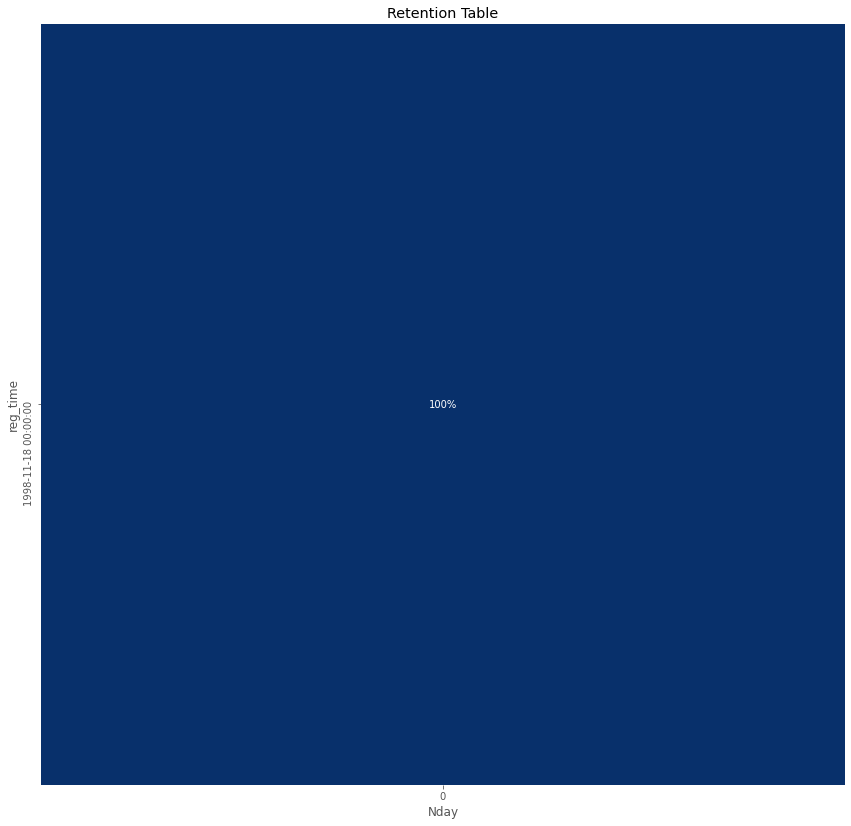

In [21]:
retention_rate(df, '1970-09-09', -2, -100)  # проверка стейтментов на работоспособность

Nday,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
reg_time,,,,,,,,,,,,,,,,
2020-09-01,1.0,0.020,0.041,0.042,0.046,0.064,0.056,0.064,0.041,0.054,0.051,0.054,0.049,0.055,0.043,0.044
2020-09-02,1.0,0.025,0.039,0.047,0.057,0.062,0.071,0.063,0.048,0.041,0.057,0.055,0.055,0.043,0.050,0.053
2020-09-03,1.0,0.023,0.054,0.047,0.065,0.070,0.085,0.063,0.055,0.063,0.063,0.055,0.058,0.060,0.055,0.053
2020-09-04,1.0,0.020,0.036,0.036,0.051,0.064,0.073,0.050,0.053,0.043,0.056,0.055,0.043,0.056,0.044,0.045
2020-09-05,1.0,0.028,0.039,0.046,0.055,0.059,0.075,0.049,0.051,0.055,0.060,0.052,0.046,0.054,0.045,0.051
2020-09-06,1.0,0.031,0.043,0.054,0.056,0.059,0.068,0.061,0.058,0.055,0.049,0.048,0.054,0.052,0.055,0.046
2020-09-07,1.0,0.029,0.042,0.054,0.051,0.064,0.073,0.052,0.041,0.056,0.060,0.057,0.046,0.051,0.042,0.051
2020-09-08,1.0,0.017,0.039,0.039,0.049,0.076,0.075,0.066,0.052,0.052,0.065,0.054,0.059,0.052,0.047,0.031
2020-09-09,1.0,0.017,0.032,0.047,0.057,0.067,0.057,0.059,0.044,0.050,0.037,0.050,0.048,0.049,0.024,NaN


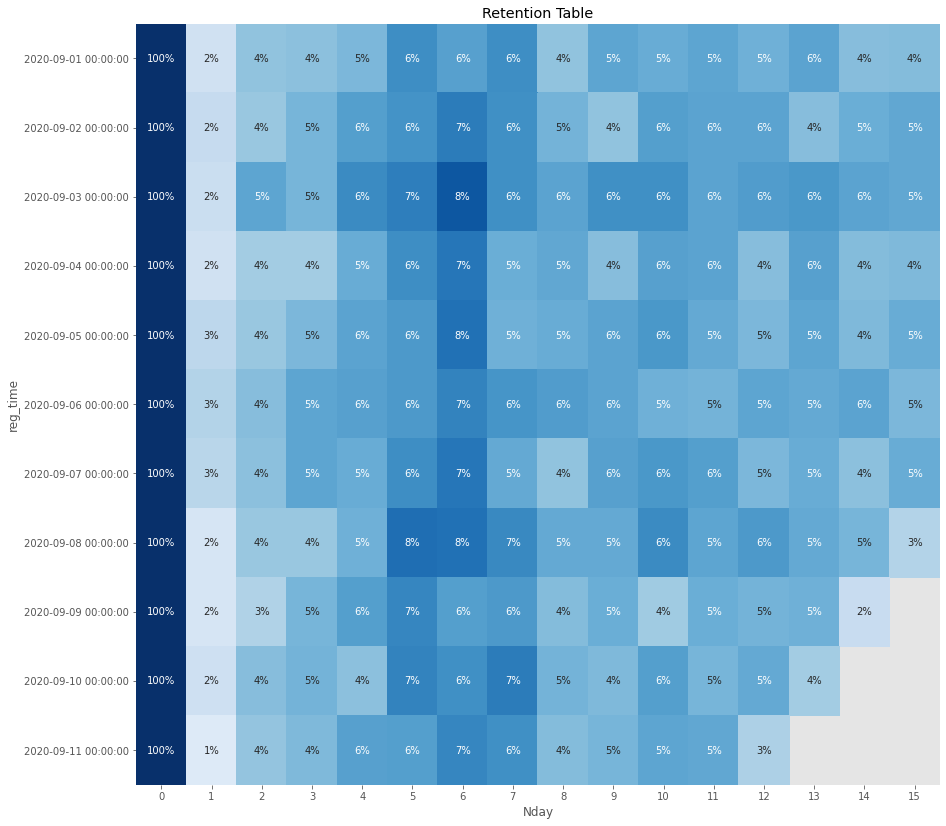

In [19]:
retention_rate(df, '2020-09-01', 10, 15)  # запуск функции

Nday,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
reg_time,,,,,,,,,,,,,,,,,,,,,
2020-01-01,1.0,0.026,0.045,0.034,0.057,0.058,0.075,0.050,0.044,0.044,...,0.044,0.035,0.027,0.038,0.031,0.040,0.036,0.033,0.033,0.024
2020-01-02,1.0,0.024,0.045,0.052,0.048,0.058,0.077,0.059,0.056,0.053,...,0.040,0.043,0.041,0.034,0.038,0.034,0.031,0.034,0.031,0.028
2020-01-03,1.0,0.023,0.034,0.044,0.045,0.069,0.075,0.054,0.045,0.042,...,0.044,0.038,0.031,0.032,0.038,0.036,0.025,0.024,0.029,0.030
2020-01-04,1.0,0.015,0.045,0.051,0.053,0.057,0.070,0.054,0.042,0.049,...,0.023,0.036,0.032,0.032,0.026,0.025,0.027,0.022,0.024,0.023
2020-01-05,1.0,0.020,0.045,0.046,0.044,0.048,0.079,0.052,0.039,0.054,...,0.044,0.034,0.038,0.035,0.037,0.032,0.036,0.018,0.034,0.024
2020-01-06,1.0,0.029,0.045,0.050,0.038,0.047,0.066,0.059,0.052,0.050,...,0.038,0.040,0.036,0.029,0.033,0.031,0.026,0.024,0.037,0.027
2020-01-07,1.0,0.019,0.049,0.044,0.064,0.050,0.085,0.051,0.057,0.053,...,0.041,0.039,0.043,0.038,0.033,0.036,0.030,0.033,0.030,0.022
2020-01-08,1.0,0.022,0.040,0.043,0.051,0.050,0.085,0.050,0.045,0.062,...,0.042,0.035,0.041,0.030,0.042,0.025,0.030,0.035,0.027,0.023
2020-01-09,1.0,0.019,0.040,0.055,0.045,0.060,0.067,0.057,0.051,0.047,...,0.037,0.033,0.035,0.035,0.032,0.035,0.029,0.033,0.023,0.021


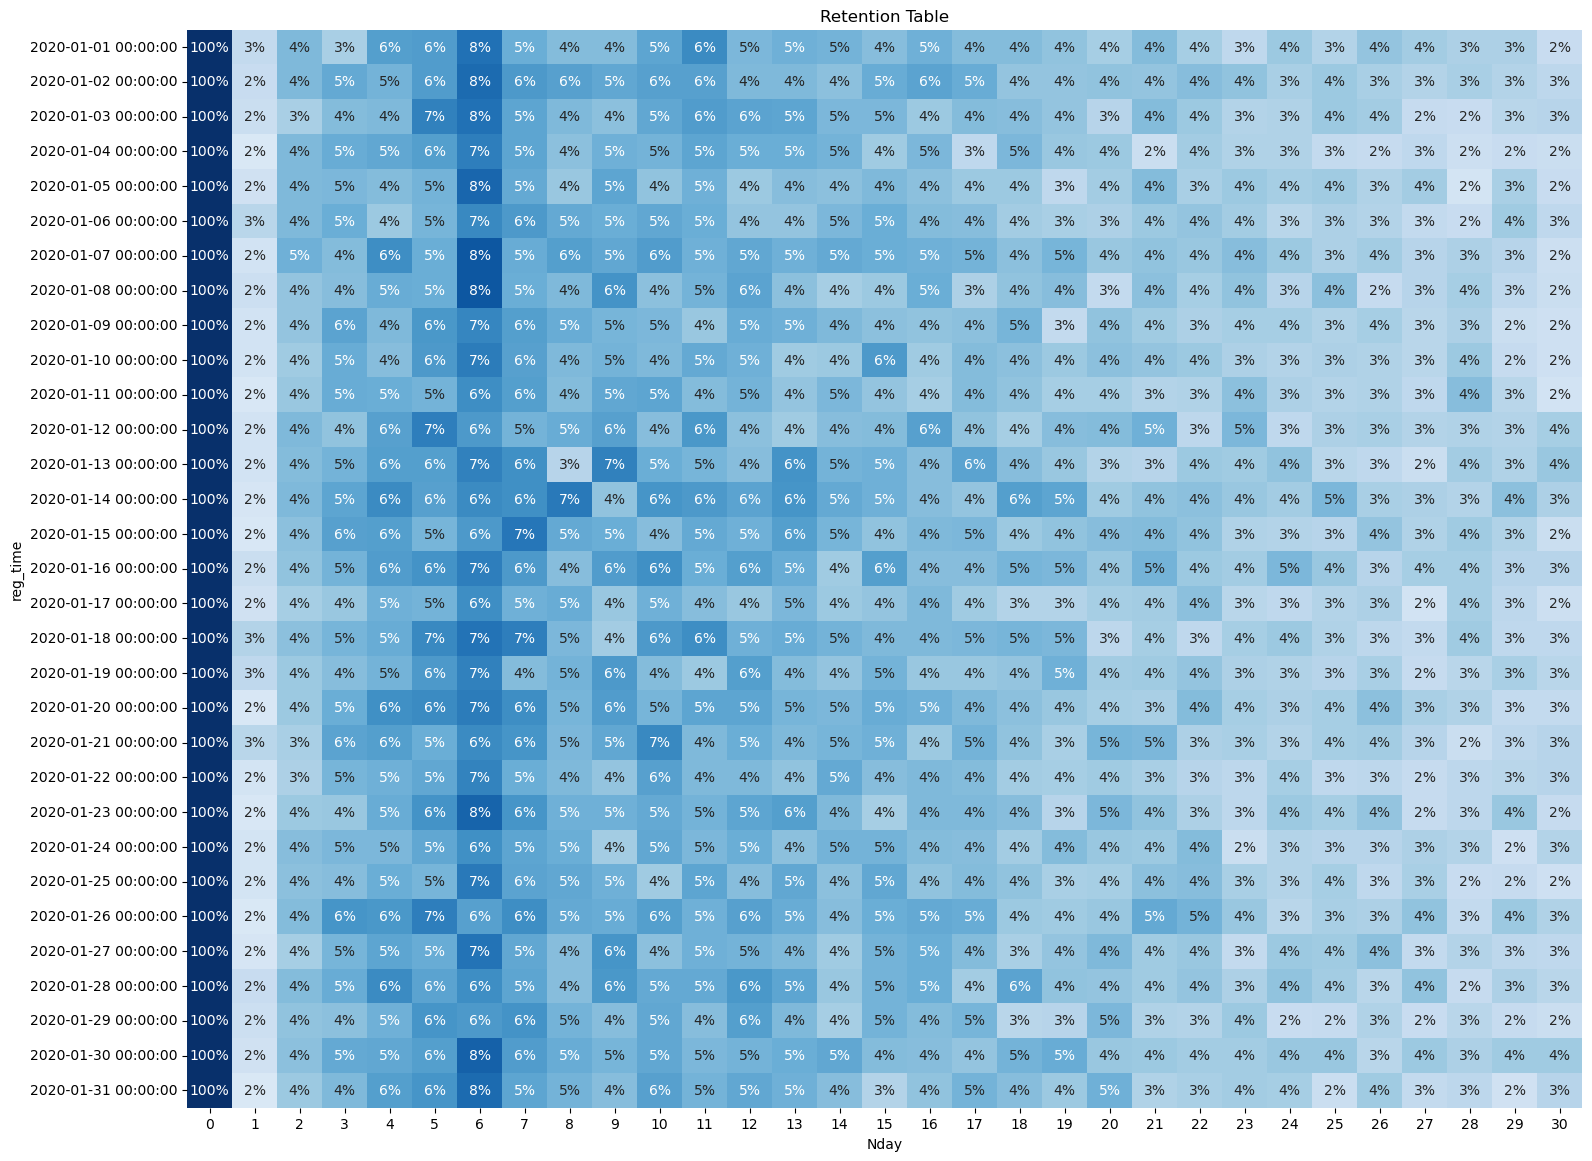

In [22]:
retention_rate(df, '2020-01-01', 30, 30)  # запуск функции на больший объем, если нужна фулл таблица то нужно
# закоментить блок визуала - так можно делать большие таблицы, 
# но ретеншн обычно считают на 3, 5, 7, 15 и 30 так что должно хватить для задачи именно в днях. 
# в других случаях можно сделать ретеншн в месяцах на год.

In [22]:
df_check = df.copy()  # проверка таблицы на корректность данных

In [23]:
df_check = df_check.query('reg_time == "2020-09-01"').copy()

In [24]:
df_check.uid.nunique()

1586

In [25]:
df_check = df_check.copy()
df_check.loc[:, 'Nday'] = (df_check['auth_time'] - df_check['reg_time']).dt.days

In [26]:
df_check.query('Nday == 1').uid.nunique()

32

In [27]:
df_check.query('Nday == 2').uid.nunique()

65

In [28]:
df_check.query('Nday == 3').uid.nunique()

67

In [29]:
res1 = round(32 / 1586, 3)
res2 = round(65 / 1586, 3)
res3 = round(67 / 1586, 3)
print(res1, res2, res3)  # проверка пройдена

0.02 0.041 0.042


#### Таким образом работает и сохранение рисунка в виде тепловой карты, имя файла тоже задано верно <a href="https://downloader.disk.yandex.ru/preview/abee4fcd0b1f9df718d4bee1e23bd63366c89f73f96e7053635db946892194c9/6449978d/X4LrIKIm4YBEj9SMSFcT-m4sVa2kvFSSrAN_izEtwH3_zO0iQM26HLXIV8A8sRGUOLP925ZqhR296QVkzbN5bA%3D%3D?uid=0&filename=Retention_Rate_2020-09-01.png&disposition=inline&hash=&limit=0&content_type=image%2Fpng&owner_uid=0&tknv=v2&size=2048x2048">Retention_Rate_2020-09-01</a>
### Task1 answer: По итогу функция работоспособна как на полном датасете, так и на ее части, дата-инженеру или команде аналитиков необходимо собрать данные в датафрейм с колонками 'uid', 'reg_time', 'auth_time', есть возможность объединить и эти функции чтобы сразу на выходе получить желаемый результат, однако такой подход ограничит возможность выполнять функцию на разные разрезы вводных данных и семплы разных датафреймов. Выводим правило, что исходные данные в базе изначально формируются только в таком виде. В конечном итоге при такой последовательности действий сохраняется быстрота выполнения функции и она должна работать с большим объемом данных.

 ### Task 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

Формат данных:

|user_id	| revenue	| testgroup |
|-----------|-----------|-----------|
|1	        |0          |	b|
|2       	|0          |	a|
|3	        |0          |	a|
|4	        |0          |	b|
|5      	|0          |	b|

In [30]:
ab_t2 = 'https://disk.yandex.ru/d/xsYD78NrIon3eA'  # загружаем датафрейм
df_t2 = get_data(ab_t2)
df_t2.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [31]:
df_t2.shape 

(404770, 3)

In [32]:
df_t2.isnull().values.sum()  # проверка на NaN

0

In [33]:
df_t2.groupby('testgroup', as_index=False).agg({'user_id': 'count', 'revenue': 'mean'})  # ARPU

,testgroup,user_id,revenue
0,a,202103,25.413720
1,b,202667,26.751287


In [34]:
(1 - 25.413720 / 26.751287) * 100  # 5% как и в условии задачи 

5.000009906065451

##### сначала посмотрим то,что на поверхности - проверим разницу (ARPPU)для тех кто купил что-то в приложении

In [35]:
df_t2.query('revenue != 0') \
    .groupby('testgroup', as_index=False) \
    .agg({'user_id': 'count', 'revenue': 'mean'})

,testgroup,user_id,revenue
0,a,1928,2663.998444
1,b,1805,3003.658172


##### 12.75% разницы в ARPPU  уже посущественнее между тему кто совершал покупки, далее проверим сколько же это в денежном эквиваленте

In [36]:
df_t2.query('revenue != 0').groupby('testgroup', as_index=False).agg({'user_id': 'count', 'revenue': 'sum'})

,testgroup,user_id,revenue
0,a,1928,5136189
1,b,1805,5421603


In [37]:
(5421603 / 5136189 - 1) * 100

5.5569216786999

##### разница в +285414 у.е. в группе "тест"('b'), revenue получается на 5.56% больше в общей сумме продаж - это c точки зрения бизнеса хороший прирост, но ни в коем случае здесь не идет речи о статистически значимых различиях

In [48]:
1928 / 202103 * 100  # однако в группе 'a' "контрольная" показатель конверсии 
# в покупку(CRM) чуть выше и составляет 0.95%

0.9539690157988748

In [49]:
1805 / 202667 * 100  # в группе 'b' или "тест" показатель 
# конверсии в покупку ниже и составляет 0.89%

0.8906235351586593

In [50]:
df_a = df_t2.query('testgroup == "a"').reset_index(drop=True)  # подготовим таблицы по группам эксперимента
df_a.head(5)

,user_id,revenue,testgroup
0,2,0,a
1,3,0,a
2,10,0,a
3,11,0,a
4,12,0,a


In [51]:
df_b = df_t2.query('testgroup == "b"').reset_index(drop=True)
df_b.head(5)

,user_id,revenue,testgroup
0,1,0,b
1,4,0,b
2,5,0,b
3,6,0,b
4,7,0,b


In [52]:
df_a.describe()  # есть пользователи которые купили на общую сумму  
# более 37к и стандартное отклонение соотвественно 920.77 показывает нам о большем разбросе данных

,user_id,revenue
count,202103.000000,202103.000000
mean,202555.909843,25.413720
std,116802.329266,920.768137
min,2.000000,0.000000
25%,101502.500000,0.000000
50%,202988.000000,0.000000
75%,303559.000000,0.000000
max,404769.000000,37433.000000


In [53]:
df_b.describe()  # максимальная сумма 4000 и стандартное отклонение соотвественно 287.32

,user_id,revenue
count,202667.000000,202667.000000
mean,202215.564389,26.751287
std,116891.926690,287.324162
min,1.000000,0.000000
25%,100855.500000,0.000000
50%,201821.000000,0.000000
75%,303602.500000,0.000000
max,404770.000000,4000.000000


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


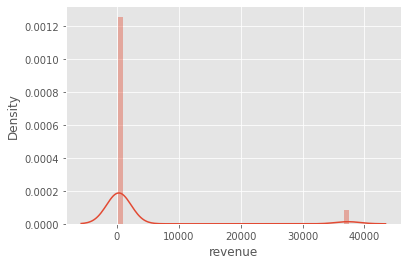

In [54]:
sns.distplot(df_a.query('revenue != 0').revenue, kde=True)  # видим эти "выбросы" на графике, в дальнейшем 
# нужно проверить на нормальность

##### далее рассмотрим покупки без предполагаемых "выбросов",но на самом деле это могут быть реальные игроки совершавшие многократные или дорогие покупки и это говорит о том, что метрика повторных покупок(Repeat Purchase Rate) или LTV очень важна, но так как мы не имеем подробной информации о транзакциях по каждому юзеру и времени этих транзакций говорить об этом сложно, поэтому и убирать их нельзя

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


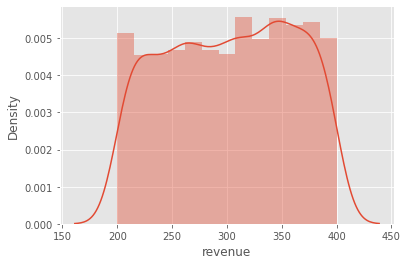

In [55]:
sns.distplot(df_a.query('revenue != 0 and revenue < 30000').revenue, kde=True)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


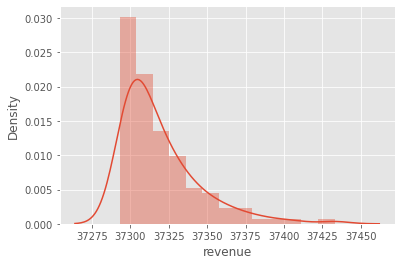

In [56]:
sns.distplot(df_a.query('revenue != 0 and revenue > 30000').revenue, kde=True)  # посмотрим на сами "выбросы"

In [57]:
df_a.query('revenue != 0 and revenue > 30000')  # 123 юзера имеют чеки от 37293 у.е.

,user_id,revenue,testgroup
210,417,37324,a
2254,4429,37304,a
2953,5778,37315,a
4080,8066,37307,a
4402,8744,37334,a
...,...,...,...
180082,360697,37347,a
189113,378669,37297,a
194438,389342,37298,a
197087,394581,37302,a


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


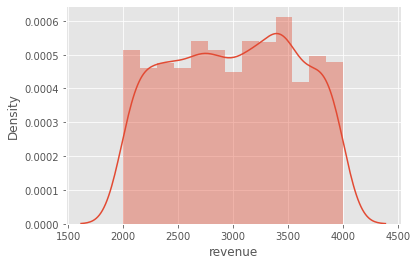

In [58]:
sns.distplot(df_b.query('revenue != 0').revenue, kde=True)  # в тестовой группе нет такого разброса 
# данных, но график не похож на нормальное распределение

   ##### Таким образом исходя из этих поверхностных наблюдений и без дальнейшего анализа трудно окончательно определить, какой из этих наборов предложений считать лучшим. Однако эти наблюдения показали, что среднее значение суммы покупки на юзеров совершивших покупки (ARPPU) для группы 'a' составляет 2663 у.е., у группы 'b' составляет 3003 у.е. С учетом большого разброса в контрольной группе(а) можно задаться вопросом, является ли случайностью то, что 123 юзера совершили покупки на сумму сильно отличающуюся от остальных в этой же группе или же это в действительни они внесли вклад в общую прибыль. В любом случае такие данные нужно проверять на статзначимость. Возможно в реальной практике бизнеса надежнее иметь юзеров, совершившие покупки в интервале от 2000 до 4000 у.е. (b), чем надеятся на меньшее количество более "состоятельных" пользователей(a), именно поэтому важна оценка такой сложившейся ситуации. В денежном эквиваленте также приемущество у группы 'b', которая на 5.26% больше и составляет 5421603 у.е. против 5136189 у.е.  Отсутствие у нас информации о времени и количестве транзакций ограничивает наш дальнейший анализ, потому что мы не сможем посмотреть на такие метрики как LTV, AOV, тогда мы бы в полной мере могли оценить природу этих данных. Важно заметить, что мы оцениваем наборы акционных предложений, в первую очередь это должно отразится на доступных нам бизнес-метриках ARPU и ARPPU. Итак исходя из этого предлагается следующее решение: 
    1. Проверить есть ли статистическая разница в двух группах(ARPU,ARPPU).
    2. Сделать выводы по результатам теста/тестов.

##### проведем тест Шапиро-Уилкара, чтобы проверить выборки на нормальность распределения.

In [59]:
stats.shapiro(df_a.revenue)

/opt/tljh/user/lib/python3.7/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


ShapiroResult(statistic=0.008876502513885498, pvalue=0.0)

In [45]:
stats.shapiro(df_b.revenue)

ShapiroResult(statistic=0.06588172912597656, pvalue=0.0)

In [46]:
stats.shapiro(df_a.query('revenue > 0').revenue)

ShapiroResult(statistic=0.2667924761772156, pvalue=0.0)

In [47]:
stats.shapiro(df_b.query('revenue > 0').revenue)

ShapiroResult(statistic=0.9583123922348022, pvalue=2.491345674771425e-22)

##### делаем вывод, что распределение в трех выборках из четырех отклоняется от нормального. Ранее на визуализации данных в виде графиков это было видно наглядно, но теперь мы точно можем быть в этом уверенны. С учетом этого и вышенаписанного приходим к тому, что нам подойдет в первую очередь метод Бутстрап и можно попробовать t-test в качестве сопровождения. 

In [60]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=10000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values
        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=-np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"quants": quants, 
            "p_value": p_value}

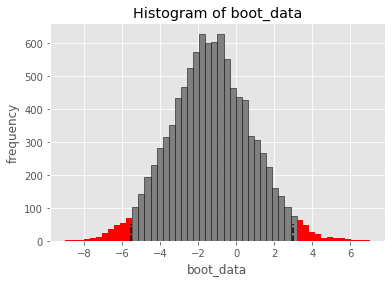

{'quants':               0
 0.025 -5.520563
 0.975  2.992313,
 'p_value': 0.5355576479752646}

In [61]:
get_bootstrap(df_a.revenue, df_b.revenue)

на выборке купивших что-то в приложении ARPPU

  0%|          | 0/10000 [00:00<?, ?it/s]

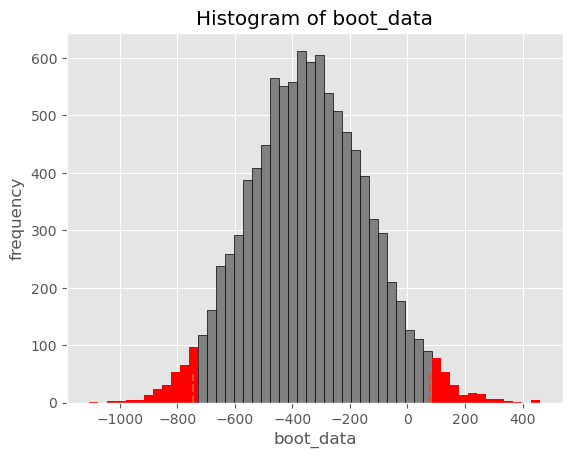

{'quants':                 0
 0.025 -745.138460
 0.975   77.749935,
 'p_value': 0.0979977114078278}

In [30]:
get_bootstrap(df_a.query('revenue > 0').revenue, df_b.query('revenue > 0').revenue)

Ну и попробуем t-test в качестве подкрепления вывода также для ARPU и ARPPU:

In [62]:
t_statistic, p_value = stats.ttest_ind(df_a.revenue, df_b.revenue)
print("P-value:", p_value)

P-value: 0.532494858971837


In [63]:
t_statistic, p_value = stats.ttest_ind(df_a.query('revenue > 0').revenue, df_b.query('revenue > 0').revenue)
print("P-value:", p_value)

P-value: 0.11153459157259504


##### Поскольку p-value больше общепринятого уровня значимости (0,05), это говорит о том, что существенной разницы между двумя группами нет. Другими словами, статистический анализ не дает доказательств в поддержку утверждения о том, что средние значения двух групп существенно отличаются.

### Task2 answer: Произведенный анализ не выявил статистической разницы между тестовой группой 'b' и контрольной группой 'a', любые наблюдаемые различия в между двумя группами могли возникнуть только в результате случайности. Выдаем рекомендацию дальше поработать над наборами предложений или дальше наблюдать за группами но уже в более расширенном варианте с временными промежутками и транзакциями.

  ### Task 3

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

### Task3 answer:

##### Конверсия (Conversion rate) - результаты события можно определить с помощью конверсии, который измерит процент игроков, успешно прошедших необходимые уровни. Метрика позволит оценить эффект от мероприятия в привлечении и удержании игроков. Здесь также неплохо было бы оценить временные промежутки прохождения уровней, такие как среднее время (time to complete) прохождения уровней, это позволит держать уровень сложности на приемлемой величине , для геймдева это один из важнейших параметров.

##### Удержание игроков (Retention rate) - отслеживать коэфициенты удержания позволит разработчикам сколько игроков они вернули и удержали, некоторые игроки могут вернуться в игру после крупного обновления, особенно это касается событий в игре, например в игру Dota2 после крупного обновления в игру вернулось 210 тыс.человек. Метрика тоже позволяет оценить интерес игроков на разнообразные события, причем мы можем посмотреть ретенш и после обновления и предпринять какие-то действия, например запустить новое событие.

##### Daily Active Users (DAU) - метрика оценивает количество уникальных пользователей, которые взаимодействовали с игрой или приложением в течении 24-часового окна. Используя эту метрику мы можем количественно оценить успех релизов контента, обновлений, событий. Если количество активных пользователей в день резко возрастает после обновления с событием, то можно сделать вывод о положительной реакции юзеров. Это метрика также может помочь отследить, то что хотят видеть пользователи в игре.

##### Продолжительность сессии (Session length) - метрика показывает на сколько долго пользователь находился в игре, как и говорилось ранее метрика поможет не только в балансировке игры, так и позволит оценить как пользователи взаимодействуют с различными областями контента. Временные метрики всегда лучше смотреть вкупе с другими метриками.

##### Метрики относящиеся к монетизации и бизнесу (AOV, Revenue per user, ARPU, LTV, CLV, ARPPU) - события обычно сопровождаются платным контентом или рекламными интеграциями.  Эти метрики позволят оценить сколько денег он потратил на игру. В данном случае можно будет отследить сроедний доход с игрока во время ивента или обновления и из этого оценить на сколько получились удачными обновление или ивент. 

##### При усложнении механики в первую очередь нужно посмотреть сколько игроков мы потеряли, это показывает метрика оттока игроков (Churn rate). Противоположность метрики удержания, поможет нам узнать сколько из-за этого игроков прекратили играть. 

##### Если при неудачной попытке игрок откатывается на несколько уровней назад, мы дополнительно сами можем  скастомизировать различные метрики, например посчитать число откатов или среднее число откатов, после какого по счету отката игроки удаляют игру ). Баланс в играх это одно из основых факторов его успеха, поэтому скорее всего у разроботчиков есть свои метрики для определения оптимальных условий. Поможет также вкупе смотреть за метрикой продолжительности сессий.

##### Также неплохим способом определить довольны ли игроки можно простым фидбеком, а именно следить за отзывами и рейтингом на площадках где мы размещены. Естественно в случае негативного изменения механики, будет больше негативных отзывов или рейтинг будет падать.

##### Таким же образом все изменения механики могут отразиться и на метриках бизнеса таким как LVT, ARPU например. Другими словами, это может отразиться на финансовой стороне, все зависит от радикальности самих изменений. Крупные недостатки, конечно же вносят больший негативный импакт. Однако стоит отметить,что более мелкие проблемы с механикой могут быть не заметны для бизнес-метрик, поэтому следить нужно за множеством других метрик, касающихся игрового процесса.